In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [22]:
df = pd.read_csv('../data/flights.csv')
print(df.shape)
df.head()

(71175, 11)


,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
0,1,MF,Boeing 737,non-schengen,KEC,17.671481,20.671481,0,2010,False,-3.989698
1,2,EW,Airbus A330,schengen,KXZ,10.588196,13.588196,0,2010,False,3.826984
2,3,MF,Airbus A330,schengen,UVR,8.968215,11.968215,0,2010,False,-20.602880
3,4,KW,Embraer E175,schengen,YOM,6.173571,10.173571,0,2010,False,-0.682961
4,5,KW,Boeing 787,schengen,PZK,14.942155,17.942155,0,2010,False,29.889728


In [23]:
# List of categorical variables
categorical_vars = ['airline', 'aircraft_type', 'origin']

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_vars)

# Perform label encoding
label_mapping = {True: 1, False: 0, 'schengen': 1, 'non-schengen': 0}
df_encoded['is_holiday'] = df['is_holiday'].map(label_mapping)
df_encoded['schengen'] = df['schengen'].map(label_mapping)

# Print the updated DataFrame
print(df_encoded.shape)
df_encoded.head()

(71175, 23)


,flight_id,schengen,arrival_time,departure_time,day,year,is_holiday,delay,airline_EW,airline_KW,...,aircraft_type_Boeing 737,aircraft_type_Boeing 787,aircraft_type_Embraer E175,origin_IPP,origin_JUV,origin_KEC,origin_KXZ,origin_PZK,origin_UVR,origin_YOM
0,1,0,17.671481,20.671481,0,2010,0,-3.989698,False,False,...,True,False,False,False,False,True,False,False,False,False
1,2,1,10.588196,13.588196,0,2010,0,3.826984,True,False,...,False,False,False,False,False,False,True,False,False,False
2,3,1,8.968215,11.968215,0,2010,0,-20.602880,False,False,...,False,False,False,False,False,False,False,False,True,False
3,4,1,6.173571,10.173571,0,2010,0,-0.682961,False,True,...,False,False,True,False,False,False,False,False,False,True
4,5,1,14.942155,17.942155,0,2010,0,29.889728,False,True,...,False,True,False,False,False,False,False,True,False,False


In [24]:
# Drop unnecessary columns
df_cleaned = df_encoded.drop(['flight_id', 'arrival_time', 'departure_time', 'day', 'year'], axis=1)

subset = df_cleaned.sample(n=10000)

# Separate X and y
X = subset.drop('delay', axis=1)
y = subset['delay']

# Print the shape of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)

# Print the updated DataFrame
X.head()

X shape: (10000, 17)
y shape: (10000,)


,schengen,is_holiday,airline_EW,airline_KW,airline_MF,aircraft_type_Airbus A320,aircraft_type_Airbus A330,aircraft_type_Boeing 737,aircraft_type_Boeing 787,aircraft_type_Embraer E175,origin_IPP,origin_JUV,origin_KEC,origin_KXZ,origin_PZK,origin_UVR,origin_YOM
18747,1,0,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False
19946,0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False
6281,0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False
23563,1,0,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False
45078,1,0,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True


In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
X_train.shape

(8000, 17)

In [27]:
# Define the Gaussian Process regression model
kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel)

In [28]:
# Train the model
gpr.fit(X_train, y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=1))

In [29]:
# Make predictions on the testing set
y_pred = gpr.predict(X_test)

In [30]:
# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: {:.2f} minutes".format(mse))
print("Mean Absolute Error: {:.2f} minutes".format(mae))
print("R-squared Score: {:.2f}".format(r2))

Mean Squared Error: 232.02 minutes
Mean Absolute Error: 12.15 minutes
R-squared Score: 0.58


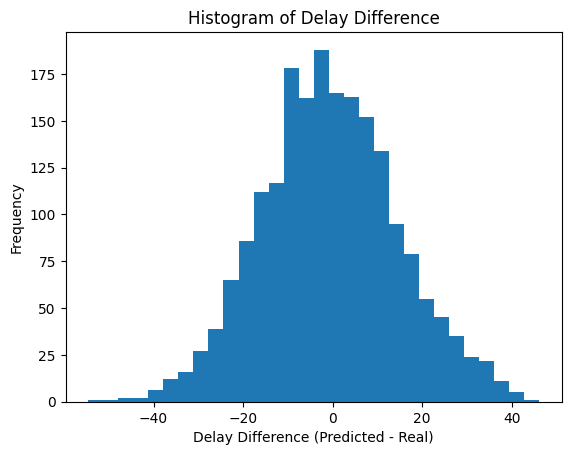

In [31]:
# Calculate the difference between predicted and real delays
delay_diff = y_pred - y_test

# Plot histogram of delay difference
plt.hist(delay_diff, bins=30)
plt.xlabel("Delay Difference (Predicted - Real)")
plt.ylabel("Frequency")
plt.title("Histogram of Delay Difference")
plt.show()